In [1]:
from jet_ML_tools import *
from data_import import data_import

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

Using Theano backend.
Using gpu device 0: GeForce GTX 660M (CNMeM is enabled with initial size: 15.0% of memory, cuDNN 5105)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# specify the inputs for which files to read in
n_files = 2
n_ev_per_file, s_range = 10000, range(1, 1 + n_files)

# read in the data from file
nevents = n_files * n_ev_per_file
data = data_import(data_type='jetimage', seed_range=s_range, path='../images/')

# split the data by quark and gluon
X_g_train, X_q_train, X_g_test, X_q_test = data_split(data[:nevents], data[nevents:], val_frac = 0, test_frac = 0.1)

In [3]:
# Adapted from: github.com/derylucio/weaksupervision

from keras.optimizers import Adam

# Weak supervision loss function
def weak_loss_function(ytrue, ypred):
    return K.square(K.sum(ypred[:,1]) - K.sum(ytrue[:,1]))

# Generates batches for training with keras
def weak_data_generator(X_g, X_q, batch_size = 512, weak = True):
    assert len(X_g) == len(X_q), "Quark and Gluon sample sizes must be the same"
    
    g_indx, q_indx, length = 0, 0, len(X_g)
    
    while True:
        # draw a random fraction in 0,1. determine the appropriate number of Q and G
        f = np.random.random()
        f = .5
        n_g, n_q = int(np.floor(batch_size * f)), int(batch_size - np.floor(batch_size * f))
          
        # read out the appropriate numbers of quark and gluons
        samples = np.concatenate((np.roll(X_g, -1 * g_indx, axis = 0)[:n_g], np.roll(X_q, -1 * q_indx, axis = 0)[:n_q]))
        labels = to_categorical(np.concatenate((np.zeros(n_g), np.ones(n_q))), 2)
                                 
        # update quark and gluon iterating indices
        g_indx, q_indx = int((g_indx + n_g)%length), int((q_indx + n_q)%length)
                                 
        # randomly shuffle the batch
        perm = np.random.permutation(np.arange(batch_size))
        samples = samples[perm]
        labels = labels[perm]

        yield samples, labels
        
# Train a network with weak supervision
def trainCNN(X_g, X_q, nb_epoch = 10, learning_rate = 0.001, val_frac = 0.1, weak = True):

    # perform a train-val split on the data
    X_g_train, X_q_train, X_g_val, X_q_val = data_split(X_g, X_q, val_frac = val_frac, test_frac = 0)
    
    X_vals = np.concatenate((X_g_val, X_q_val))
    y_vals = to_categorical(np.concatenate((np.zeros(len(X_g_val)),np.ones(len(X_g_val)))),2)
    
    # construct the CNN with the following hyperparameters. Parameters based on arXiv:1612.01551
    hps = {'img_size': 33, 'nb_conv': [8,4,4], 'nb_filters': [64, 64, 64],
           'nb_neurons': 128, 'nb_pool': [2, 2, 2], 'dropout': [.25, .5, .5, .5],
           'nb_channels': 1, 'patience': 3, 'out_dim' : 2, 'batch_size' : 10}
    
    CNN_model = conv_net_construct(hps, compiled = False)
    earlystopper = EarlyStopping(monitor="val_loss", patience= hps['patience'])
    
    if weak:
        CNN_model.compile(loss = weak_loss_function, optimizer=Adam(lr=learning_rate), metrics = ['accuracy']) 
        
    else:
        CNN_model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics = ['accuracy'])
            
    CNN_model.summary()
    CNN_model.fit_generator(generator = weak_data_generator(X_g_train, X_q_train, hps['batch_size'], weak),
                             samples_per_epoch = 2*len(X_g_train), nb_epoch = nb_epoch,
                             validation_data = (X_vals, y_vals), callbacks = [earlystopper])

    return CNN_model

In [4]:
model = trainCNN(X_g_train, X_q_train, weak = True, nb_epoch = 3)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 64, 26, 26)    4160        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 64, 26, 26)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 64, 13, 13)    0           activation_1[0][0]               
____________________________________________________________________________________________________
spatialdropout2d_1 (SpatialDropo (None, 64, 13, 13)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

KeyboardInterrupt: 

In [392]:
acc = 1 - (np.sum(1 - model.predict_classes(X_q_test)) + np.sum(model.predict_classes(X_g_test)))/(2*len(X_q_test))

2000/2000 [==============================] - 9s     


In [394]:
print(acc)

0.71525


In [134]:
a = [0,1,2,3,4,5,6,7,8]

np.roll(a,-2)[0]

2

In [210]:
gen = weak_data_generator(X_g_train, X_q_train)

In [376]:
samples, targets = next(gen)

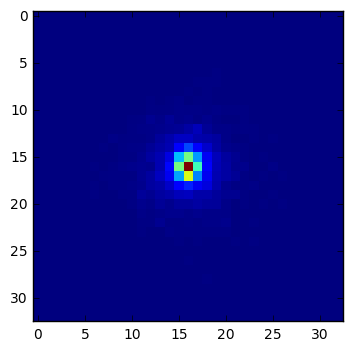

In [377]:
plt.imshow(np.mean(samples[:int(528/2)], axis = 0)[0], interpolation = 'none')

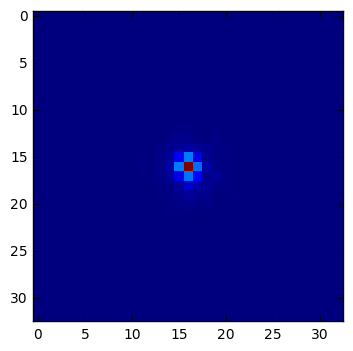

In [378]:
plt.imshow(np.mean(samples[int(528/2):], axis = 0)[0], interpolation = 'none')